<a href="https://colab.research.google.com/github/leticiaram/Modelacion-Epidemiologica/blob/main/SIR_R_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#%load_ext rpy2.ipython
# se usa con %%R en cada celda
# ver https://colab.research.google.com/gist/xiaonilee/cfd263ebef98b1d60aa57e1ebc0ec29d/rincolab.ipynb#scrollTo=zvKjhpcS8wqI

In [1]:
install.packages("rstan")
library("rstan")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: StanHeaders


rstan version 2.32.7 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [2]:
options(mc.cores = parallel::detectCores())

In [3]:
install.packages("deSolve")
library(deSolve)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Creamos Datos sintéticos

time,S,I,R
0,2999998,2.000000,0.0000000
1,2999997,2.173808,0.3476161
2,2999997,2.362720,0.7254417
3,2999996,2.568049,1.1361013
4,2999996,2.791222,1.5824490
5,2999995,3.033789,2.0675861


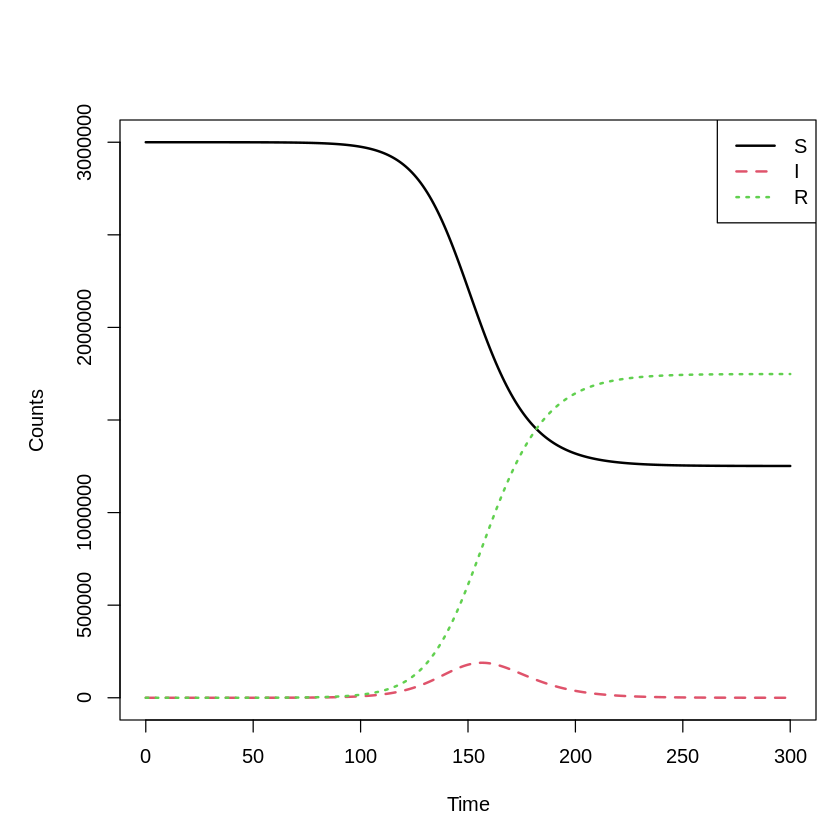

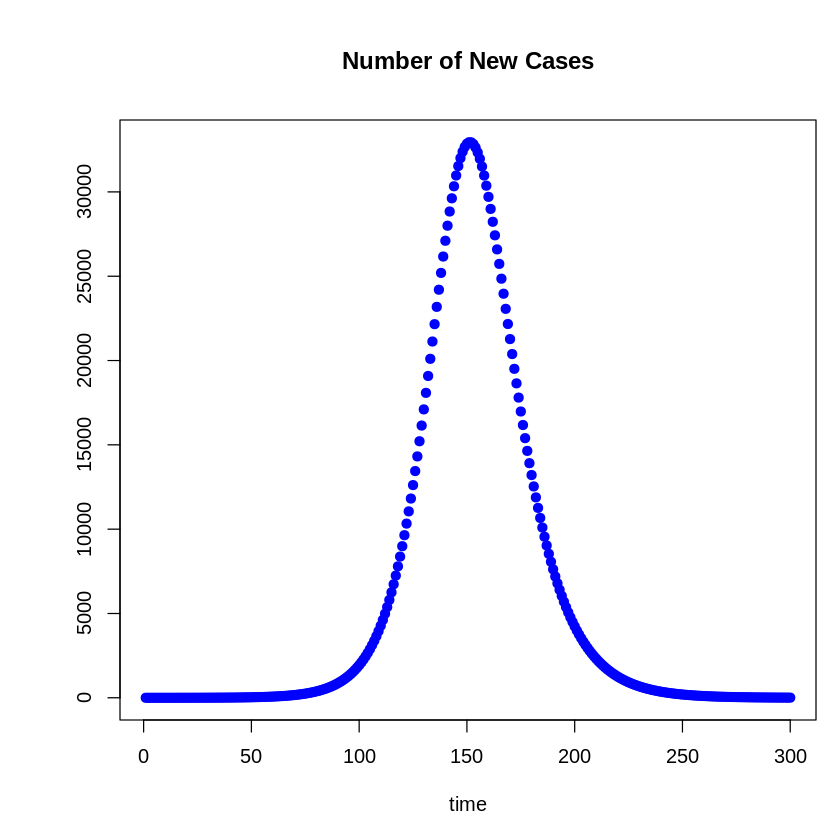

In [4]:

# Solver del modelo SIR determinista
SIR_model<-function(theta,t=tiempos){
  SIRmod <- function(t, x, theta) {
    with(as.list(c(theta, x)),
         {
           dS <- -bet*S*I/N
           dI <- bet*S*I/N-gam*I
           dR <- gam*I
           res <- c(dS, dI, dR)
           list(res)
         }
    ) }
  ## Solver
  out <- lsoda(X_ini, t, SIRmod, theta)
  out[which(out[,3]<0),3]<-0
  return(out)
}

# Condiciones iniciales

N <- 3.e6  #pop_size

I_0 <- 2.0
S_0 <- N-I_0
R_0 <- 0
X_ini = c(S = S_0, I = I_0, R = R_0)

# Verdaderos par'ametros
gamma_par = 1 / 6.0                 # 0.1666667
beta_par = 1.5*gamma_par            # 0.25
theta=c(bet=beta_par, gam=gamma_par)

#tiempos del cual observar la soluci'on del sistema
t_length = 300
grid_size = 301
t_vec = seq(0, 300, by=1)

res <- SIR_model(theta,t_vec)

head(res)

#Plot epidemic curves
par(mar = c(5,5,5,1))
matplot(res[,1],res[,-1],t = "l", lwd = 2, xlab = "Time", ylab = "Counts")
legend("topright", c("S","I","R"), col = 1:3, lty = 1:3, lwd = 2)


# We obtain the number of new cases each day
W = res[1:grid_size-1, 2] - res[2:grid_size, 2]

plot(res[-1,1],W,pch=19,col="blue",xlab="time",ylab="",main="Number of New Cases")

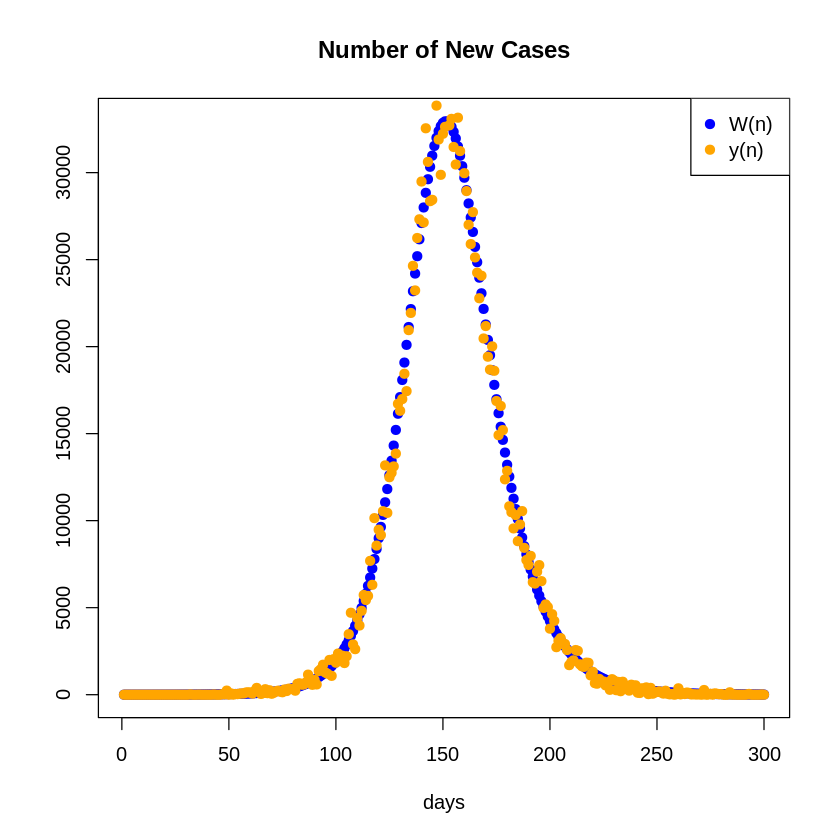

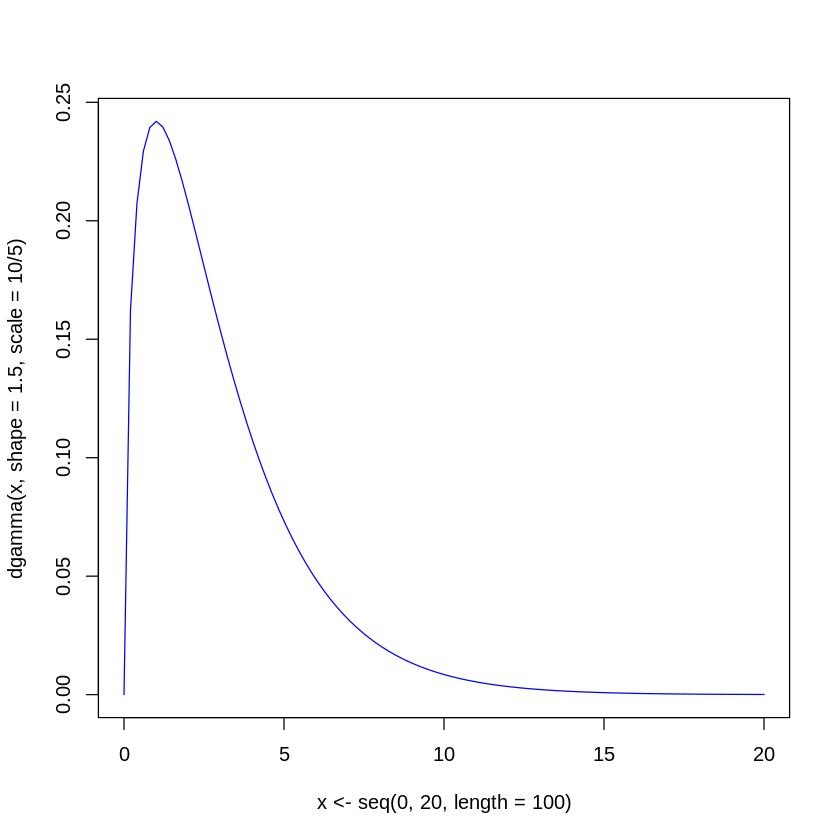

In [6]:
# We add noise
set.seed(123)

library("MASS")
?rnegbin
pp <- 0.01
y <- rnegbin(n = length(W), mu = W, theta = W * pp * (pp+1))

plot(res[-1,1], W, pch = 19,col = "blue",xlab = "days",ylab = "",main = "Number of New Cases")
lines(res[-1,1], y, t = "p",pch = 19,col = "orange")
legend("topright", c("W(n)","y(n)"), col = c("blue","orange"), pch=19)

# Graficamos la densidad previa
?rgamma
plot(x <- seq(0,20,length=100), dgamma(x,shape = 1.5,scale = 10/5), t = "l", col = "blue")

In [10]:
# Preparamos Datos
SIR_data = list(n_obs = length(t_vec)-1,
                y = y,
                x0 = X_ini,
                t0 = -0.000001,
                t_sam = t_vec
                )


In [13]:
cat("
functions {
  array[] real diff(array[] real x) {   //This function is to compute the daily incidence
    int m = num_elements(x);
    array[m - 1] real result;
    for (i in 1:(m-1)) {
      result[i] = x[i] - x[i+1];
    }
    return result;
  }

  array[] real phi_diff(array[] real x, real phi, int n_obs) {   //This function is to compute the first parameter of neg binomial
    int m = num_elements(x);
    array[m - 1] real result;
    for (i in 1:n_obs) {
       result[i] = phi * abs(diff(x)[i]);
       if(result[i]<1e-6){
          result[i] = 1e-6;
       }
    }
    return result;
  }

  vector SIR(         // This is the SIR model.
      real t,         // time
      vector x,       // state vector SEIR
      vector theta    // parameters (beta, gamma, sigma)
      ) {
      vector[3] dx_dt;
      dx_dt[1] = -(theta[1] * x[2] * x[1]) / (x[1]+x[2]+x[3]);
      dx_dt[2] = (theta[1] * x[2] * x[1]) / (x[1]+x[2]+x[3]) - theta[2]*x[2];
      dx_dt[3] = theta[2]*x[2];
      return dx_dt;
  }
}
data {
  int n_obs;                    // Number of days
  array[n_obs] int y;           // The observed data  (daily incidence)
  real N;
  vector[3] x0;                 // Initial conditions (data)
  real t0;                       // Initial time point (zero)
  array[n_obs+1] real t_sam;      // Time points that were sampled
}
transformed data {
}
parameters {
  vector<lower=0>[2] theta;
  real<lower=0> phi_inv;         // inverse of one NB's parameter
}
transformed parameters{
  real<lower=0> phi = 1. / phi_inv;
}
model {
  theta[1] ~ gamma(1.5,0.5);    //beta
  theta[2] ~ gamma(1.5,0.5);    //gamma
  array[n_obs+1] vector[3] x = ode_rk45(SIR, x0, t0, t_sam, theta);   // Output from the ODE solver
  phi_inv ~ exponential(5);
  y ~ neg_binomial_2(phi_diff(x[ ,1],phi,n_obs), phi);
}
generated quantities {
  real R0 = theta[1] / theta[2];
  //real recovery_time = 1 / theta[2];
}
", file = "SIR_model.stan")

In [66]:
fit <- stan(file = 'SIR_model.stan', data = SIR_data, chains = 1, iter = 2000,
            verbose = TRUE, init = c(0.1,0.1,0.1))


TRANSLATING MODEL '' FROM Stan CODE TO C++ CODE NOW.

CHECKING DATA AND PREPROCESSING FOR MODEL 'anon_model' NOW.

COMPILING MODEL 'anon_model' NOW.

STARTING SAMPLER FOR MODEL 'anon_model' NOW.

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.007708 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 77.08 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%] 

Inference for Stan model: anon_model.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

             mean se_mean   sd     2.5%      25%      50%      75%    97.5%
theta[1]     0.26    0.00 0.02     0.22     0.25     0.26     0.27     0.30
theta[2]     0.17    0.00 0.02     0.13     0.16     0.17     0.19     0.22
phi_inv      0.97    0.00 0.06     0.85     0.93     0.97     1.01     1.10
phi          1.04    0.00 0.07     0.91     0.99     1.03     1.08     1.17
R0           1.49    0.00 0.07     1.37     1.45     1.48     1.53     1.65
lp__     -2103.41    0.08 1.15 -2106.22 -2104.01 -2103.10 -2102.53 -2102.09
         n_eff Rhat
theta[1]   194    1
theta[2]   196    1
phi_inv    248    1
phi        236    1
R0         205    1
lp__       232    1

Samples were drawn using NUTS(diag_e) at Mon Oct 13 04:12:15 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale r

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)

Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”


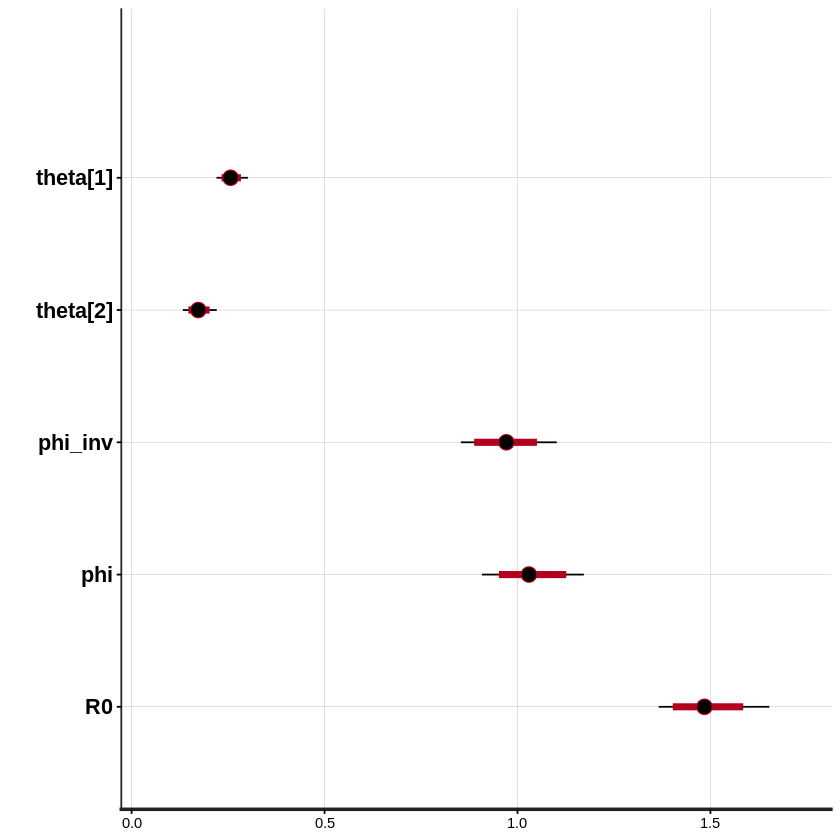

Warning message in par(usr):
“argument 1 does not name a graphical parameter”


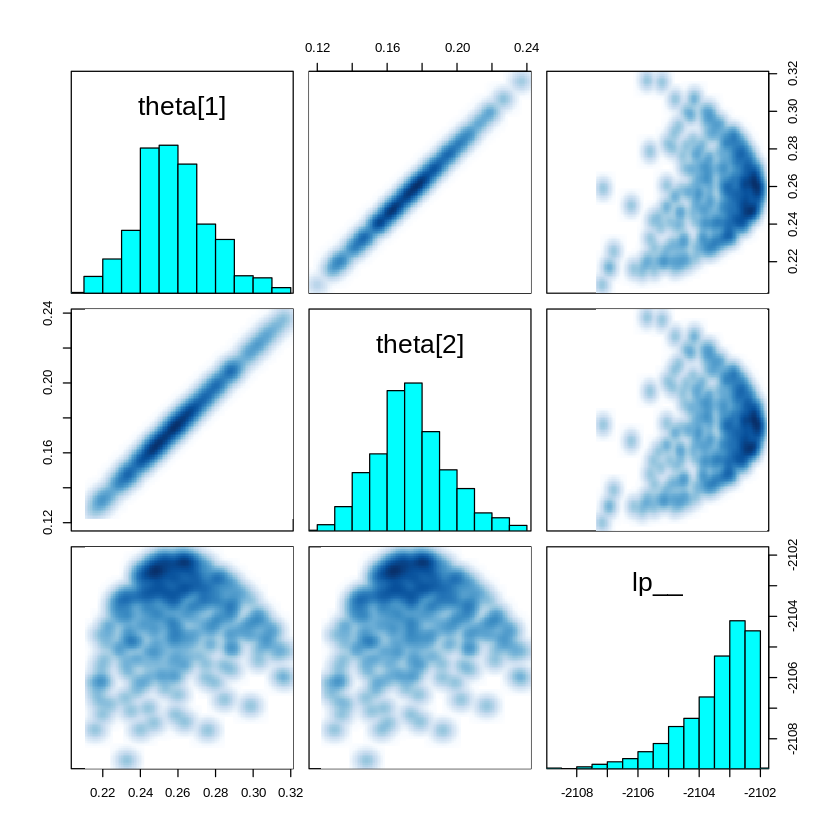

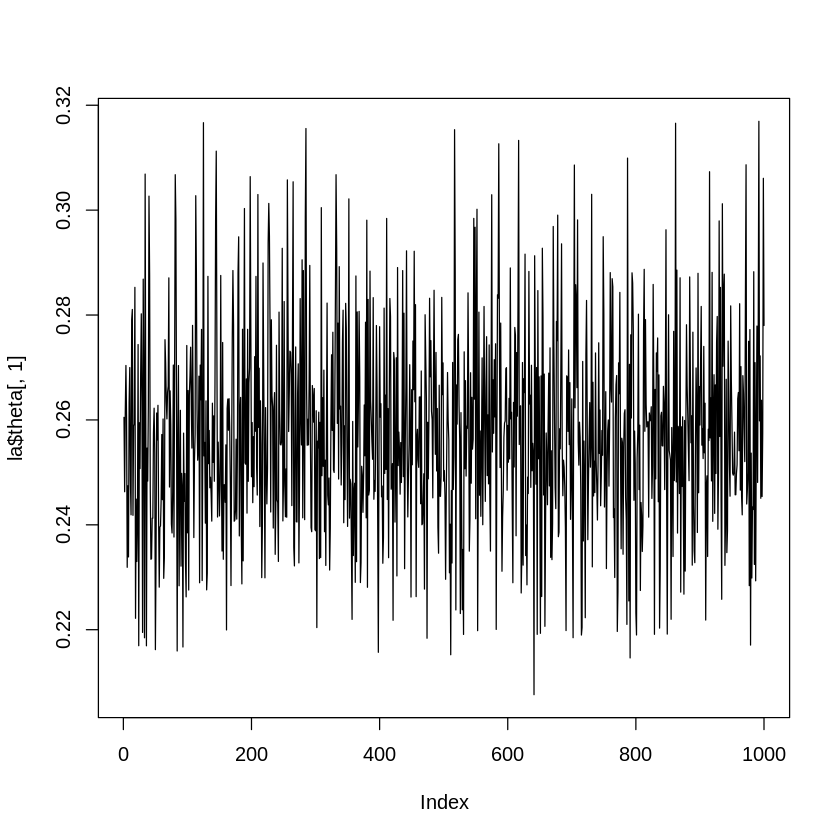

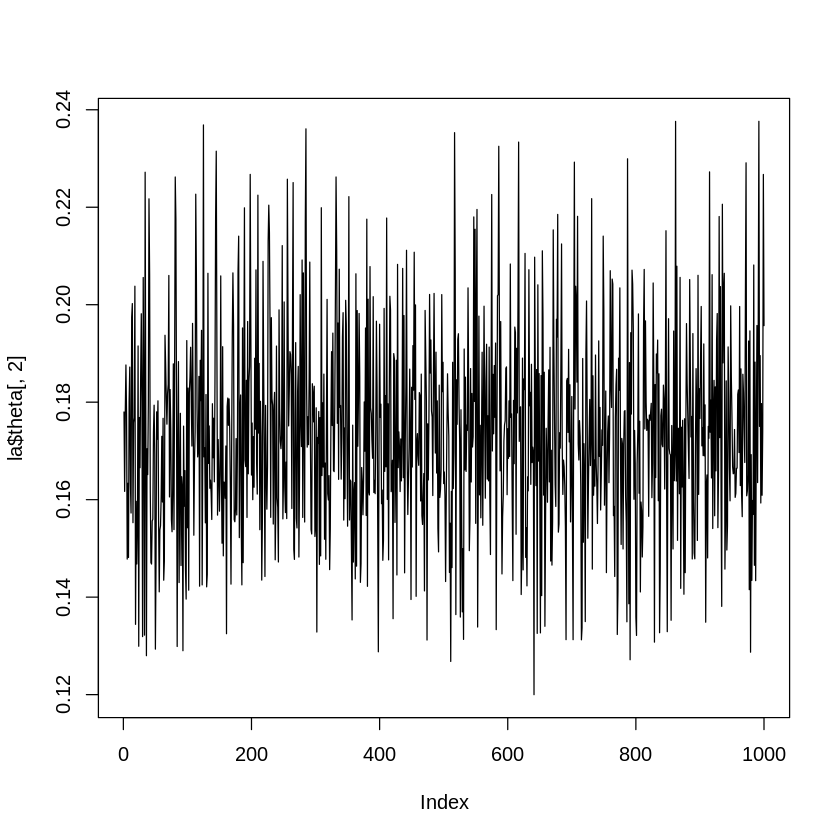

In [68]:
print(fit)
plot(fit)
pairs(fit, pars = c("theta", "lp__"))

la <- extract(fit, permuted = TRUE) # return a list of arrays
plot(la$theta[,1],t="l")  #beta
plot(la$theta[,2],t="l")  #gamma


In [33]:
install.packages("bayesplot")
#library(remotes)
#install_version("bayesplot", version = "1.9.0", repos = "http://cran.us.r-project.org")
library("bayesplot")
install.packages("rstanarm")
library("rstanarm")


plyr     (NA -> 1.8.9) [CRAN]
reshape2 (NA -> 1.4.4) [CRAN]


Installing 2 packages: plyr, reshape2

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘plyr’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘reshape2’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘/tmp/RtmpyGJbBw/remotes1a596b594ea5/bayesplot’ had non-zero exit status”


ERROR: Error in library("bayesplot"): there is no package called ‘bayesplot’


In [21]:
library("ggplot2")

In [70]:
posterior <- extract(fit, inc_warmup = TRUE, permuted = FALSE)

In [71]:
color_scheme_set("mix-blue-pink")
p <- mcmc_trace(fit,  pars = c("theta[1]","theta[2]"), n_warmup = 100,
                facet_args = list(nrow = 2, labeller = label_parsed))
p + facet_text(size = 15)


ERROR: Error in color_scheme_set("mix-blue-pink"): could not find function "color_scheme_set"


In [72]:
posterior <- as.matrix(fit)

plot_title <- ggtitle("Posterior distributions",
                      "with medians and 80% intervals")
mcmc_areas(posterior,
           pars = c("theta[1]", "theta[2]"),
           prob = 0.8) + plot_title


color_scheme_set("red")

matplot(posterior[,c('theta[1]','theta[2]')],t="l",lty=1)

ERROR: Error in mcmc_areas(posterior, pars = c("theta[1]", "theta[2]"), prob = 0.8): could not find function "mcmc_areas"


In [80]:
fit


Inference for Stan model: anon_model.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

             mean se_mean   sd     2.5%      25%      50%      75%    97.5%
theta[1]     0.26    0.00 0.02     0.22     0.25     0.26     0.27     0.30
theta[2]     0.17    0.00 0.02     0.13     0.16     0.17     0.19     0.22
phi_inv      0.97    0.00 0.06     0.85     0.93     0.97     1.01     1.10
phi          1.04    0.00 0.07     0.91     0.99     1.03     1.08     1.17
R0           1.49    0.00 0.07     1.37     1.45     1.48     1.53     1.65
lp__     -2103.41    0.08 1.15 -2106.22 -2104.01 -2103.10 -2102.53 -2102.09
         n_eff Rhat
theta[1]   194    1
theta[2]   196    1
phi_inv    248    1
phi        236    1
R0         205    1
lp__       232    1

Samples were drawn using NUTS(diag_e) at Mon Oct 13 04:12:15 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale r

In [79]:
names(fit)

[1] "theta[1]" "theta[2]" "phi_inv"  "phi"      "R0"       "lp__"

In [82]:
str(posterior)

 num [1:1000, 1:6] 0.251 0.251 0.25 0.252 0.253 ...
 - attr(*, "dimnames")=List of 2
  ..$ iterations: NULL
  ..$ parameters: chr [1:6] "theta[1]" "theta[2]" "phi_inv" "phi" ...


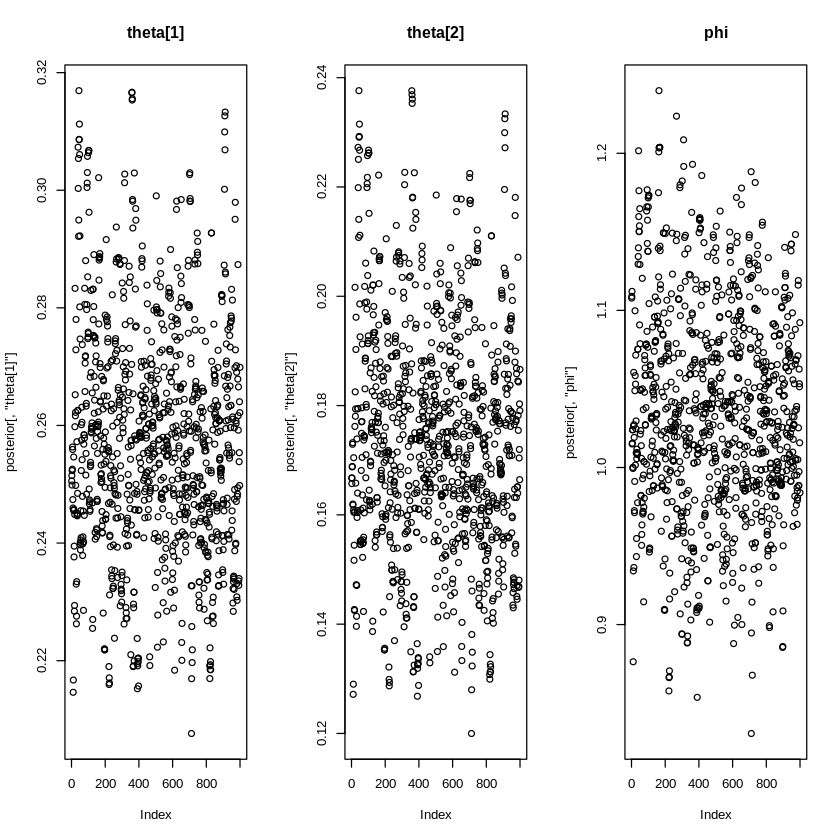

In [85]:

par(mfrow=c(1,3))
plot(posterior[,"theta[1]"],main="theta[1]")
plot(posterior[,"theta[2]"],main="theta[2]")
plot(posterior[,"phi"],main="phi")

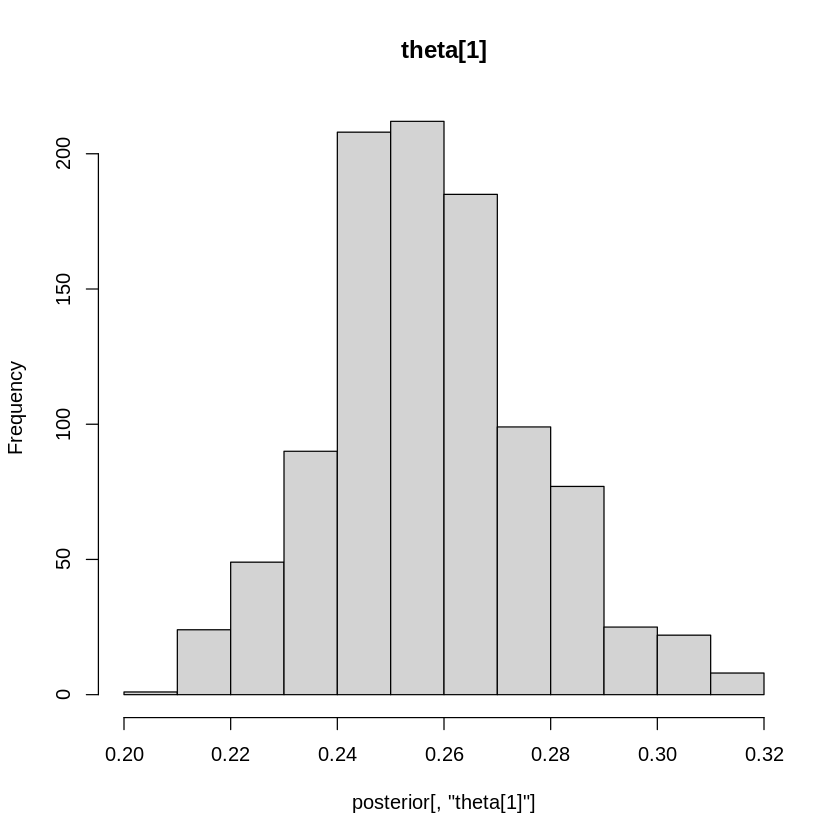

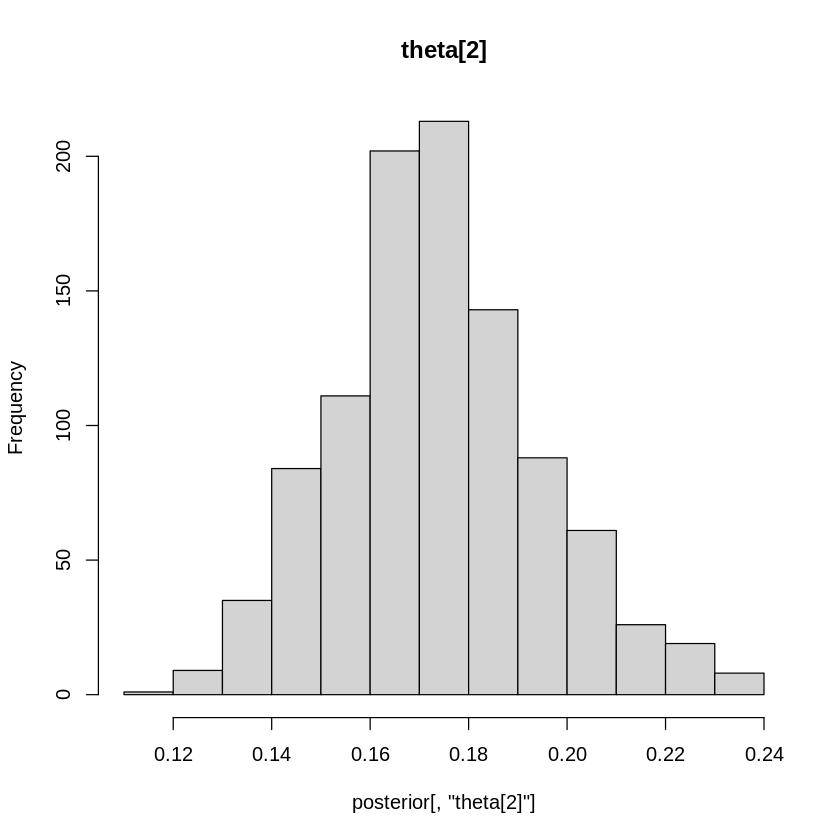

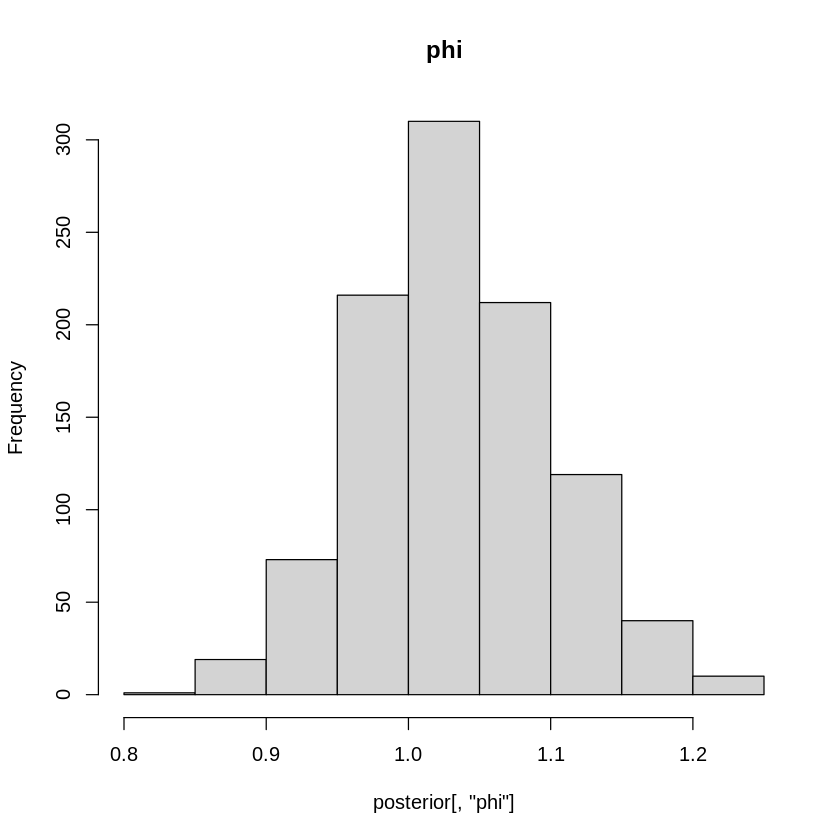

In [86]:
hist(posterior[,"theta[1]"],main="theta[1]")
hist(posterior[,"theta[2]"],main="theta[2]")
hist(posterior[,"phi"],main="phi")

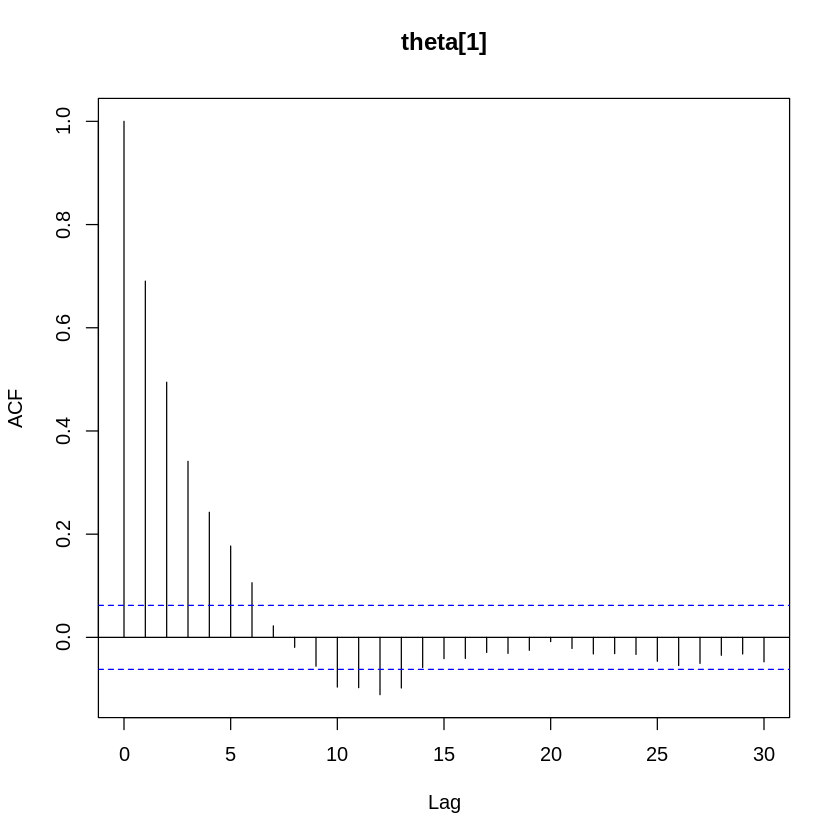

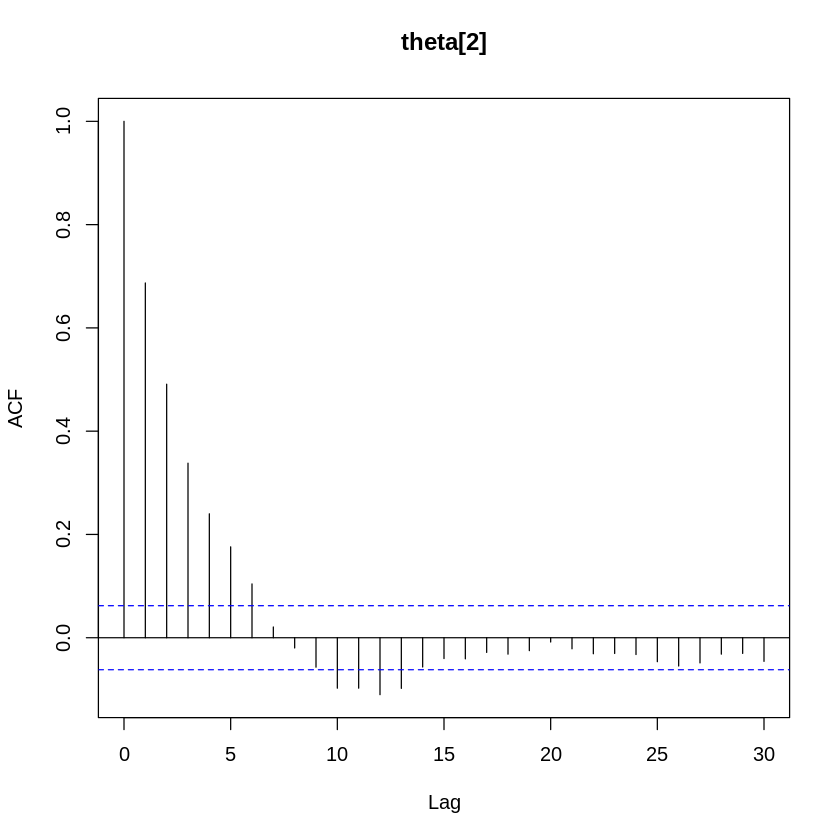

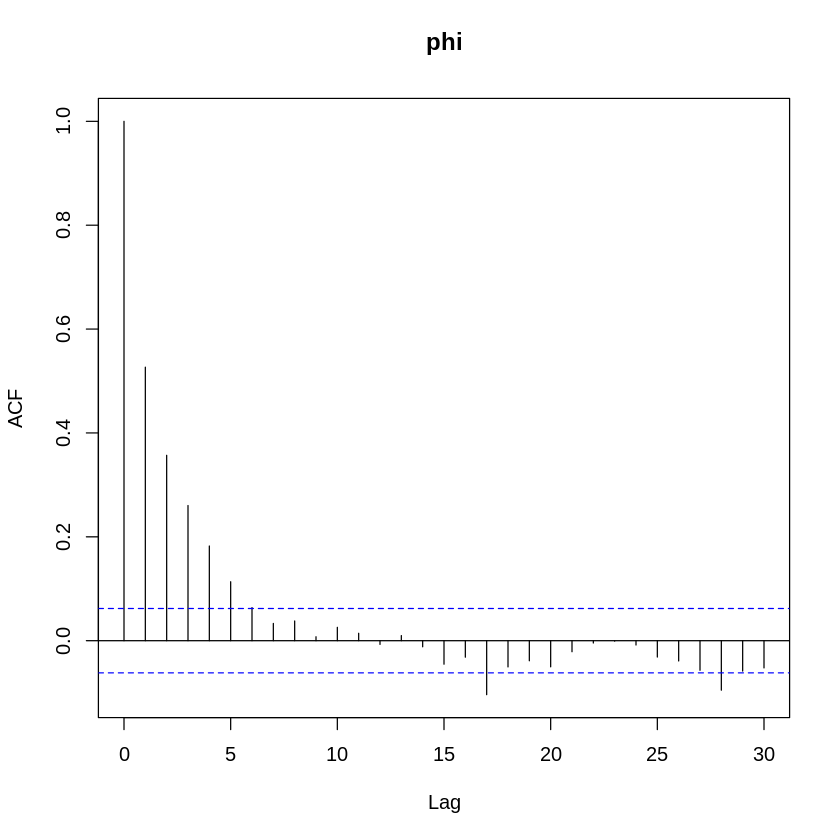

In [88]:
acf(posterior[,"theta[1]"],main="theta[1]")
acf(posterior[,"theta[2]"],main="theta[2]")
acf(posterior[,"phi"],main="phi")

In [89]:
post1<-posterior[seq(1,1000,by=5),"theta[1]"]
post2<-posterior[seq(1,1000,by=5),"theta[2]"]
post4<-posterior[seq(1,1000,by=5),"phi"]

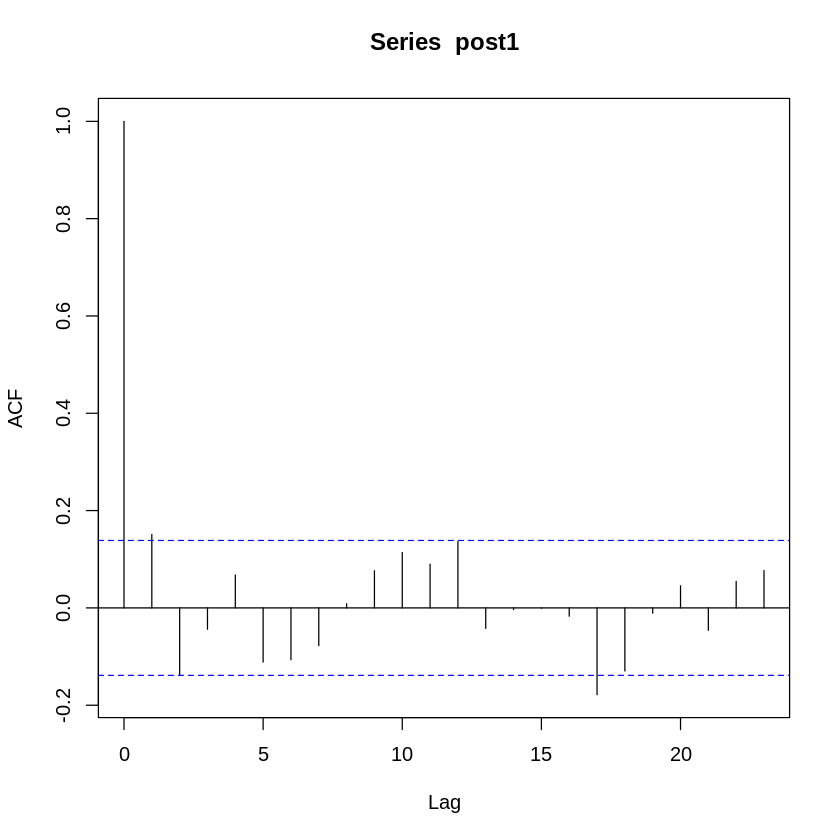

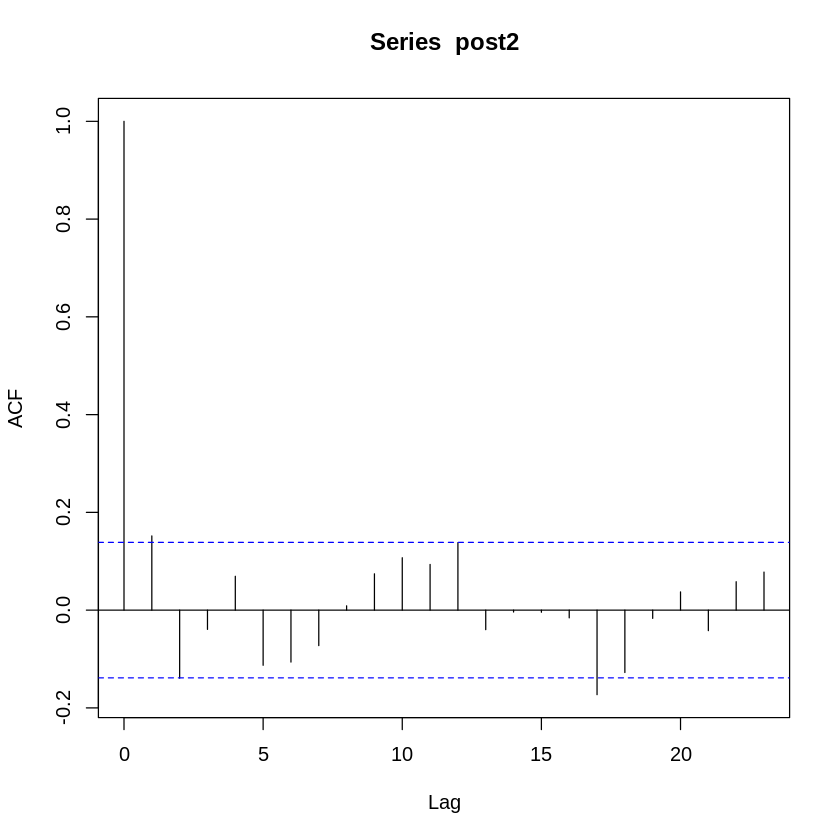

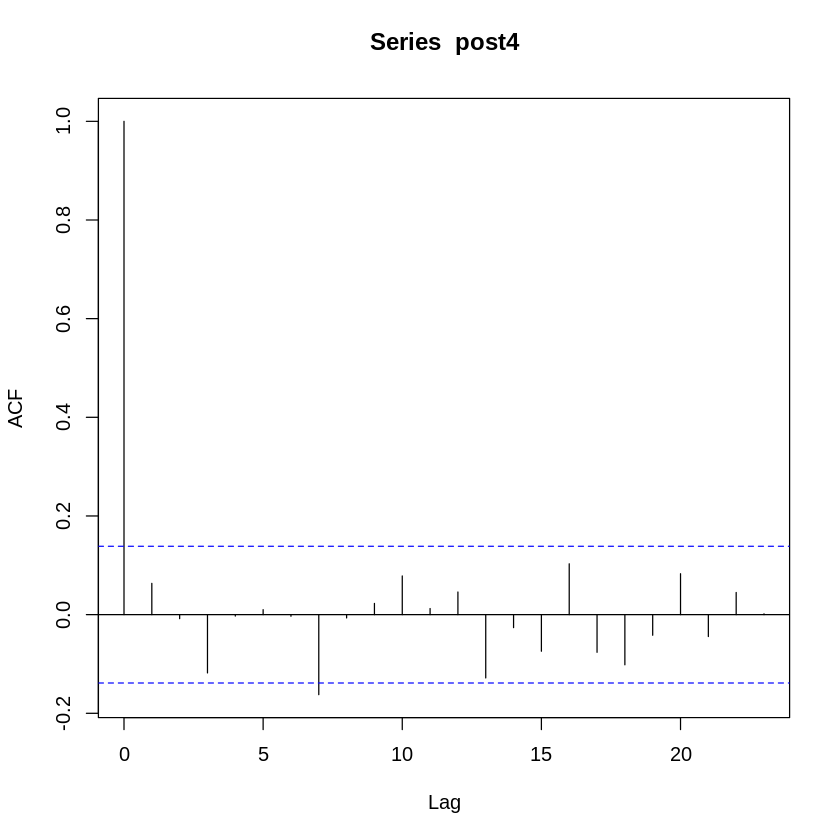

In [90]:
acf(post1)
acf(post2)
acf(post4)

In [91]:
summary(post1)
summary(post2)
summary(post4)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2152  0.2448  0.2575  0.2575  0.2668  0.3156 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1268  0.1602  0.1741  0.1738  0.1844  0.2361 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8307  0.9883  1.0252  1.0329  1.0788  1.2036 

In [92]:
quantile(post1,c(0.25,0.975) )
quantile(post2,c(0.25,0.975) )
quantile(post4,c(0.25,0.975) )

25%     97.5% 
0.2447854 0.3028129

25%     97.5% 
0.1602046 0.2227288

25%     97.5% 
0.9883344 1.1591509